<center>
    <h1>Assignment 1 - Recurrent Neural Models for Sequence Labeling</h1>
    <h2>Natural Language Processing</h2>
    <h3>Antonio Politano, Enrico Pittini, Riccardo Spolaor and Samuele Bortolato</h3>
    <h4>antonio.politano2@studio.unibo.it; enrico.pittini@studio.unibo.it, riccardo.spolaor@studio.unibo.it, samuele.bortolato@studio.unibo.it</h4>
</center>



---



Assignment description: see `Assignment.ipynb`. This notebook should be read and run before the notebook `2) pos tagging.ipynb`.

In this notebook, the handling of the OOV words is addressed.

To run this notebook, the following data should be present in the rigth folders.
- The dataset should be put inside the `dataset` folder. Link to the dataset: https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip
- The $100$ dimensional GloVe embedding model `glove.6B.100d.txt` should be put inside the `glove_pretrained` folder. Link to the GloVe embedding model: https://nlp.stanford.edu/data/glove.6B.zip

For more detailed informations about the used functions, look into the corresponding docstrings inside the python files, inside the `utils` folder.

In [1]:
import numpy as np

In [2]:
# Settings for autoreloading

%load_ext autoreload
%autoreload 2

In [3]:
# Settings for reproducibility

import random 
import torch
import os

random_seed = 44

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

os.environ['TF_DETERMINISTIC_OPS'] = '1'

# 1 Preliminaries

## 1.1 Dataset loading

The training, validation and test datasets are loaded, splitting the documents into sentences. Each dataset has the form `texts, labels`, where the former is a list of list of strings, representing sentences the words, while the latter is a list of list of strings, representing the corresponding sentences POS tags.

As preprocessing, all the words are trasformed into lowercase. Moreover, all the numbers are substituted with the same special token `[num]`. The idea is that most of them have the same POS tag, i.e. `CD` Cardinal Numbers, therefore they are equivalent from the POS tagging perspective.

In [4]:
from utils.dataset_loader import load_datasets

(texts_train, labels_train), (texts_val, labels_val), (texts_test, labels_test) = load_datasets(folder_path='dataset', 
                                                                                                divide_by_sentence=True,
                                                                                                group_numbers=True)

## 1.2 GloVe loading

The embedding model, which is the standard GloVe embedding model in this case, is loaded, using $100$ as embedding dimension. The embedding model is implemented as a dictionary from words to the corresponding embedding vectors.

In [5]:
from utils.embedding_model_handler import load_embedding_model

embedding_dimension = 100

GLOVE_embeddings = load_embedding_model(folder_path='glove_pretrained', embedding_dim=embedding_dimension)

In [6]:
print(f'Embedding model size: {len(GLOVE_embeddings)}')  

Embedding model size: 400000


# 2 OOV terms handling
In this section, the OOV of the training, validation and test sets are handled.

## 2.1 General explanation
The same procedure is applied three times: the first for the training set OOV words, the second for the validation set OOV words and the third for the test set OOV words.

1. First of all, the standard GloVe embedding model is expanded with the embeddings for the training set OOV words. These embedding vectors are trained using the GloVe procedure, as described in the paper. The co-occurrence matrix between tokens is built in order to perform such procedure. While the embeddings of the training set OOV words are trained, the embeddings of the already known words (standard GloVe) are kept frozen.

2. Then, the current embedding model is further expanded with the embeddings for the validation set OOV words, using the same procedure. The co-occurrence matrix is built using both the training and validation sets. While the embeddings of the validation set OOV words are trained, the embeddings of the already known words (standard GloVe + OOV train) are kept frozen.

3. Finally, the current embedding model is further expanded with the embeddings for the test set OOV words, using the same procedure. The co-occurrence matrix is built using the training, validation and test sets. While the embeddings of the test set OOV words are trained, the embeddings of the already known words (standard GloVe + OOV train + OOV val) are kept frozen.

For more details about this procedure of expanding the embedding model with the OOV words, see the documentation inside the `oov_handler.py` file. As brief explanation, the standard GloVe procedure is used, which uses the weigths matrices $W, \tilde{W}$ and the bias vectors $b, \tilde{b}$. In the end of the training, the matrix $W + \tilde{W}$ represents the  embedding matrix, containing the embeddings. In practice, only the embeddings of the OOV words are trained, while the embeddings of the known terms are enforced to stay as they are. The values of the parameters $W, \tilde{W}, b, \tilde{b}$ are initialized to random for the OOV words, while for the known words they are initialized to the values of the same parameters obtained from the previous call of the procedure, if any (e.g. in the call for training the OOV of the validation set, the parameters values obtained from the previous call for training the OOV of the training set are used). 

## 2.2 OOV Terms Handling (Train set)

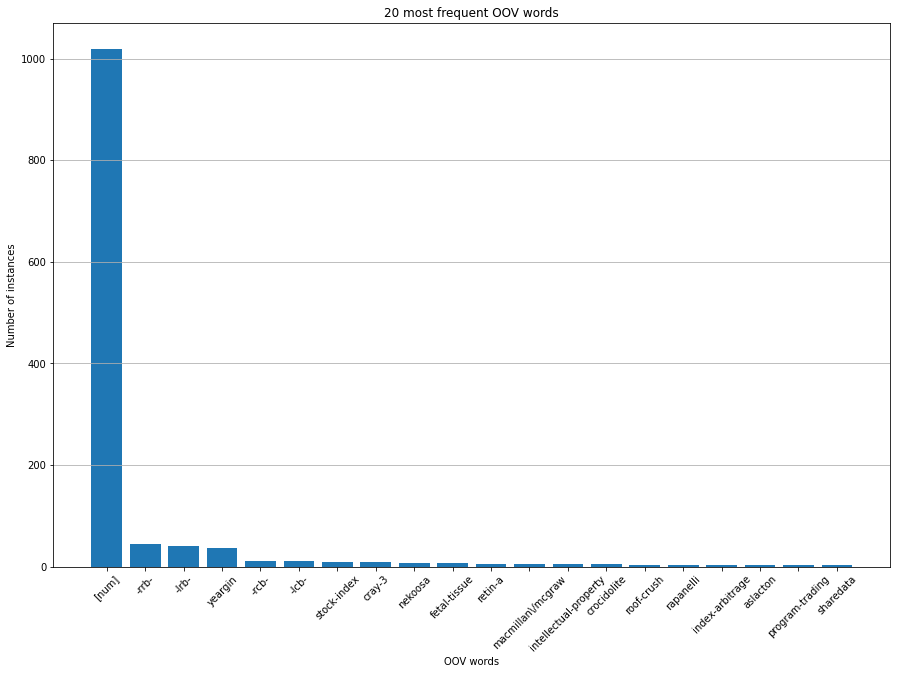

In [7]:
from utils.dataset_analysis import OOV_analysis
OOV_words, proportion_OOV_words, OOV_words_counts_dict = OOV_analysis(embedding_model=GLOVE_embeddings, texts=texts_train, plot=True)

*Notice that the most frequent OOV token is our special `[num]` token.*

In [8]:
print(f'Number of training OOV words: {len(OOV_words)}')
print(f'Proportion of training OOV words: {proportion_OOV_words:.2f}')

Number of training OOV words: 306
Proportion of training OOV words: 0.04


Extension of the embedding model with the training set OOV words.

Building co-occurrence matrix...
Co-occurrence matrix shape: (6978, 6978)

Training OOV words...
epochs: 10 loss: 337066.78
epochs: 20 loss: 102351.48
epochs: 30 loss: 35865.98
epochs: 40 loss: 14003.272
epochs: 50 loss: 6302.808
epochs: 60 loss: 3503.0837
epochs: 70 loss: 2336.2612
epochs: 80 loss: 1878.4071
epochs: 90 loss: 1781.1444
epochs: 100 loss: 1576.4067


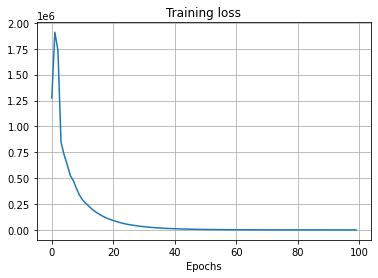

In [12]:
from utils.oov_handler import extend_embedding_model

# `extended_embedding_model` is the new embedding model.
# `vocabulary_training` is the vocabulary used for the training set.
# `trained_parameters_dict_training` is a dict containing the parameters W, \tilde{W}, b, \tilde{b} returned by this call, for
# initializing the next call.
extended_embedding_model, vocabulary_training, trained_parameters_dict_training = extend_embedding_model(embedding_model=GLOVE_embeddings,
                                                                                                        texts=texts_train)

In [11]:
print(f'Extended embedding model size: {len(extended_embedding_model)}')  

Extended embedding model size: 400306


## 2.3 OOV Terms Handling (Val set)

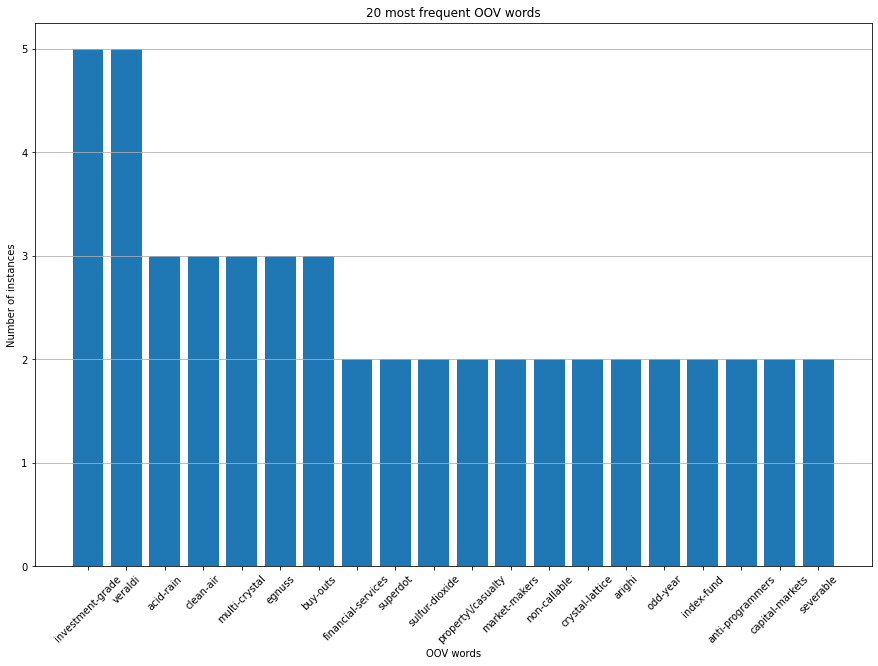

In [12]:
from utils.dataset_analysis import OOV_analysis
OOV_words, proportion_OOV_words, OOV_words_counts_dict = OOV_analysis(embedding_model=extended_embedding_model, texts=texts_val, 
                                                                      plot=True)

In [13]:
print(f'Number of validation OOV words: {len(OOV_words)}')
print(f'Proportion of validation OOV words: {proportion_OOV_words:.2f}')

Number of validation OOV words: 150
Proportion of validation OOV words: 0.03


Extension of the embedding model with the training set OOV words.

Building co-occurrence matrix...
Co-occurrence matrix shape: (9208, 9208)

Training OOV words...
epochs: 10 loss: 49093.43
epochs: 20 loss: 18453.02
epochs: 30 loss: 7271.8384
epochs: 40 loss: 3556.788
epochs: 50 loss: 2046.6659
epochs: 60 loss: 1458.4879
epochs: 70 loss: 1215.4784
epochs: 80 loss: 1186.6027
epochs: 90 loss: 1217.2107
epochs: 100 loss: 1240.431


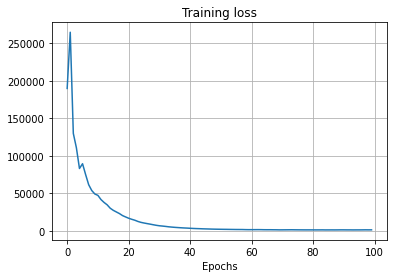

In [14]:
from utils.oov_handler import extend_embedding_model

# `extended_embedding_model` is the new embedding model.
# `vocabulary_trainVal` is the vocabulary used for the training set and validation set.
# `trained_parameters_dict_trainVal` is a dict containing the parameters W, \tilde{W}, b, \tilde{b} returned by this call, for
# initializing the next call.
extended_embedding_model, vocabulary_trainVal, trained_parameters_dict_trainVal = extend_embedding_model(embedding_model=extended_embedding_model,
                                                                                 texts=texts_train+texts_val,
                                                                                 previous_vocabulary=vocabulary_training,
                                                                                 previous_trained_parameters_dict=trained_parameters_dict_training)

In [15]:
print(f'Extended embedding model size: {len(extended_embedding_model)}')  

Extended embedding model size: 400456


## 2.4 OOV Terms Handling (Test set)

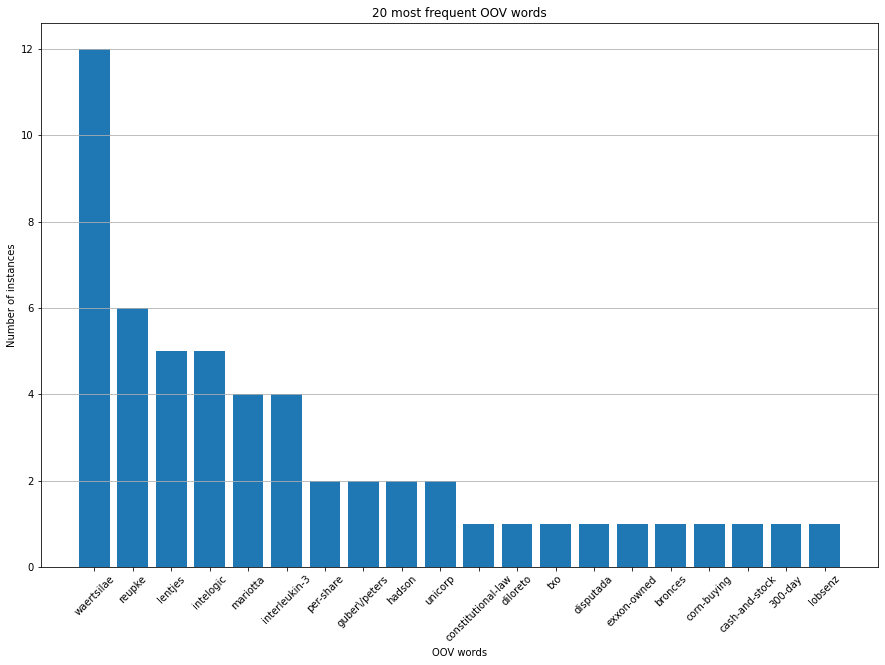

In [16]:
from utils.dataset_analysis import OOV_analysis
OOV_words, proportion_OOV_words, OOV_words_counts_dict = OOV_analysis(embedding_model=extended_embedding_model, texts=texts_test, 
                                                                      plot=True)

In [17]:
print(f'Number of validation OOV words: {len(OOV_words)}')
print(f'Proportion of validation OOV words: {proportion_OOV_words:.2f}')

Number of validation OOV words: 85
Proportion of validation OOV words: 0.03


Building co-occurrence matrix...
Co-occurrence matrix shape: (10060, 10060)

Training OOV words...
epochs: 10 loss: 28810.117
epochs: 20 loss: 10209.896
epochs: 30 loss: 3946.196
epochs: 40 loss: 2059.0955
epochs: 50 loss: 1435.0854
epochs: 60 loss: 1228.1321
epochs: 70 loss: 1193.787
epochs: 80 loss: 1127.1276
epochs: 90 loss: 1143.2853
epochs: 100 loss: 1307.6227


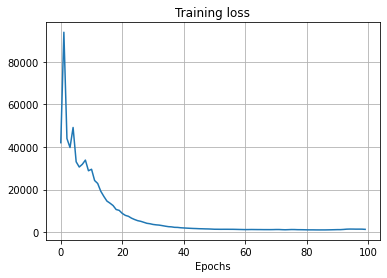

In [18]:
from utils.oov_handler import extend_embedding_model

# `extended_embedding_model` is the new embedding model.
# `vocabulary_trainValTest` is the vocabulary used for the training set, validation set and test set.
# `trained_parameters_dict_trainValTest` is a dict containing the parameters W, \tilde{W}, b, \tilde{b} returned by this call.
extended_embedding_model, vocabulary_trainValTest, trained_parameters_dict_trainValTest = extend_embedding_model(embedding_model=extended_embedding_model,
                                                                                  texts=texts_train+texts_val+texts_test,
                                                                                  previous_vocabulary=vocabulary_trainVal,
                                                                                  previous_trained_parameters_dict=trained_parameters_dict_trainVal)

In [19]:
print(f'Extended embedding model size: {len(extended_embedding_model)}')  

Extended embedding model size: 400541


## Saving the extended Glove embeddings

In [18]:
from utils.embedding_model_handler import store_embedding_model

store_embedding_model(embedding_path=f'glove_pretrained/extended_glove.{embedding_dimension}d.txt', embedding_model=extended_embedding_model)

100%|██████████| 400541/400541 [01:28<00:00, 4546.15it/s]
